In [9]:
!pip install torchmetrics
!pip install torchvision

import torchvision
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random

In [11]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [12]:
from sklearn.metrics import r2_score

In [13]:
def ReadSplitDataFile(file_name):
  subject = {"segments": [], "segment_lengths": [], "id": -1, "Age": -1, "Height(cm)": -1, "Weight(kg)": -1, "Hemoglobin(g/L)": -1, "Gender": -1}
  with open(file_name) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    k = 0

    red1 = []
    red2 = []
    ir1 = []
    ir2 = []
    lengths = []
    for row in csv_reader:
      if k == 1:
        subject["id"] = int(row[5])
        subject["Age"] = int(row[6])
        subject["Height(cm)"] = float(row[7])
        subject["Weight(kg)"] = float(row[8])
        subject["Hemoglobin(g/L)"] = float(row[9])

        if row[10] == "male":
          subject["Gender"] = 1
        else:
          subject["Gender"] = 0

      if k > 0:
        red1.append(float(row[0]))
        red2.append(float(row[1]))
        ir1.append(float(row[2]))
        ir2.append(float(row[3]))
        lengths.append(float(row[4]))

        if len(red1) == 100:
          subject["segments"].append([red1, red2, ir1, ir2])
          subject["segment_lengths"].append(sum(lengths) / len(lengths))
          red1 = []
          red2 = []
          ir1 = []
          ir2 = []
          lengths = []
      k += 1

# rationalize and preprocess //normalize and embed using pytorch embedding -> focus on the centeral question and which part of the signals is important(?) interpertable
# 1D CNN with 4 channels
# End use?
# advanced architecture, less features selections ?
# ????? keep the kernel small (GX BOOST)


  subject["segments"] = np.array(subject["segments"])
  return subject

In [14]:
from google.colab import drive
drive.mount('/content/drive')

subject = ReadSplitDataFile("/content/drive/MyDrive/Colab Notebooks/766/data/1.csv")


Mounted at /content/drive


In [15]:
subjects = []
for i in range(1, 59):
  subjects.append(ReadSplitDataFile("/content/drive/MyDrive/Colab Notebooks/766/data/" + str(i) + ".csv"))

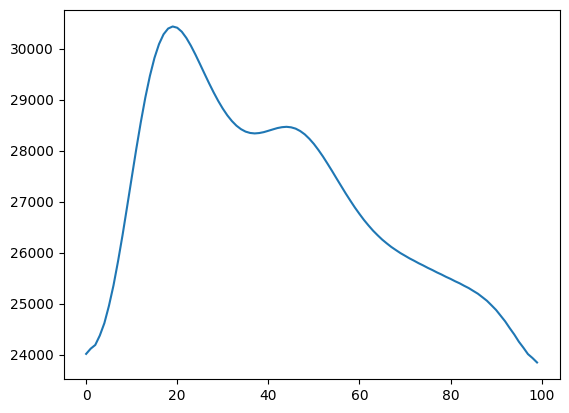

In [16]:
plt.plot(subjects[29]["segments"][1][3])
plt.show()

In [17]:
shuffled_subjects = subjects.copy()
random.shuffle(shuffled_subjects)
split = int(0.8*len(shuffled_subjects))
training_split, test_split = shuffled_subjects[:split], shuffled_subjects[split:len(shuffled_subjects)]

In [18]:
training_data = []

for subject in training_split:
  for i in range(len(subject["segments"])):
    segment_data = {}
    segment_data["segment"] = subject["segments"][i]
    segment_data["id"] = subject["id"]
    segment_data["Age"] = subject["Age"]
    segment_data["Height(cm)"] = subject["Height(cm)"]
    segment_data["Weight(kg)"] = subject["Weight(kg)"]
    segment_data["Hemoglobin(g/L)"] = subject["Hemoglobin(g/L)"]
    segment_data["Gender"] = subject["Gender"]
    segment_data["length"] = subject["segment_lengths"][i]
    training_data.append(segment_data)

random.shuffle(training_data)

In [19]:
test_data = []

for subject in test_split:
  for i in range(len(subject["segments"])):
    segment_data = {}
    segment_data["segment"] = subject["segments"][i]
    segment_data["id"] = subject["id"]
    segment_data["Age"] = subject["Age"]
    segment_data["Height(cm)"] = subject["Height(cm)"]
    segment_data["Weight(kg)"] = subject["Weight(kg)"]
    segment_data["Hemoglobin(g/L)"] = subject["Hemoglobin(g/L)"]
    segment_data["Gender"] = subject["Gender"]
    segment_data["length"] = subject["segment_lengths"][i]
    test_data.append(segment_data)

random.shuffle(test_data)

In [20]:
print(len(training_data))
print(len(test_data))

3546
942


In [21]:
train_segments = []
train_meta_data = []
train_targets = []
for segment in training_data:
  train_segments.append(segment["segment"])
  train_targets.append(segment["Hemoglobin(g/L)"])
  train_meta_data.append([segment["Age"], segment["Height(cm)"], segment["Weight(kg)"], segment["Gender"], segment["length"]])

train_segments = np.array(train_segments)
train_targets = np.array(train_targets)
train_meta_data = np.array(train_meta_data)

In [22]:
train_targets = train_targets.reshape(len(train_targets), 1)
print("Target shape:", train_targets.shape)

print("Segment shape:", train_segments.shape)
print("Meta data shape:", train_meta_data.shape)

Target shape: (3546, 1)
Segment shape: (3546, 4, 100)
Meta data shape: (3546, 5)


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionLSTM(nn.Module):
    def __init__(self, meta_data_size=5, lstm_hidden_size=64, lstm_layers=1):
        super(RegressionLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )
        self.fc1 = nn.Linear(lstm_hidden_size + meta_data_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x, meta_data):

        x = x.squeeze(1)
        x = x.permute(0, 2, 1)

        out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]

        combined = torch.cat([h_last, meta_data], dim=1)

        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x


In [24]:
import torch.nn as nn
import torch.optim as optim

model = RegressionLSTM(
    meta_data_size=5,
    lstm_hidden_size=64
)

# Same loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1/500  Train MSE: 2644.4922  Train MAE: 32.5717  Val MSE:   187.6329  Val MAE:   10.9051
Epoch 2/500  Train MSE: 164.3719  Train MAE: 10.1995  Val MSE:   138.2645  Val MAE:   9.1839
Epoch 3/500  Train MSE: 122.6171  Train MAE: 8.6852  Val MSE:   106.4224  Val MAE:   8.0128
Epoch 4/500  Train MSE: 103.2925  Train MAE: 7.9402  Val MSE:   96.6630  Val MAE:   7.5724
Epoch 5/500  Train MSE: 97.1397  Train MAE: 7.5707  Val MSE:   90.8340  Val MAE:   7.2653
Epoch 6/500  Train MSE: 90.4085  Train MAE: 7.2600  Val MSE:   84.6573  Val MAE:   6.9990
Epoch 7/500  Train MSE: 87.8016  Train MAE: 7.1125  Val MSE:   80.1226  Val MAE:   6.8065
Epoch 8/500  Train MSE: 82.2532  Train MAE: 6.9619  Val MSE:   81.6647  Val MAE:   6.9957
Epoch 9/500  Train MSE: 83.9739  Train MAE: 7.1462  Val MSE:   79.6179  Val MAE:   7.0149
Epoch 10/500  Train MSE: 80.6439  Train MAE: 6.9751  Val MSE:   79.4121  Val MAE:   6.9894
Epoch 11/500  Train MSE: 78.4061  Train MAE: 6.9049  Val MSE:   76.1610  Val MAE:   6.84

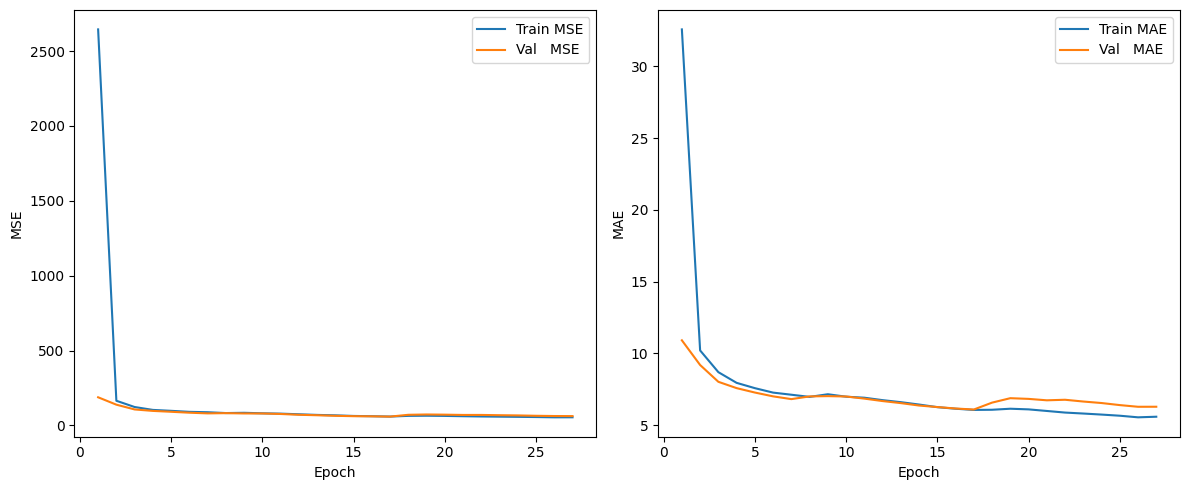


Final Validation MAE: 6.08 g/L


In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



seg_tr, seg_val, meta_tr, meta_val, y_tr, y_val = train_test_split(
    train_segments, train_meta_data, train_targets,
    test_size=0.2, random_state=41
)

y_tr = y_tr.reshape(-1,1)
y_val= y_val.reshape(-1,1)

model     = RegressionLSTM(meta_data_size=5, lstm_hidden_size=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

patience         = 10
best_val_loss    = float('inf')
epochs_no_improve= 0
best_weights     = copy.deepcopy(model.state_dict())

num_epochs = 500
batch_size = 16

train_mse, train_mae = [], []
val_mse,   val_mae   = [],   []

for epoch in range(1, num_epochs+1):

    model.train()
    running_mse = 0.0
    all_trues, all_preds = [], []

    for i in range(0, len(seg_tr), batch_size):
        xb = torch.tensor(seg_tr[i:i+batch_size], dtype=torch.float32).unsqueeze(1)
        xm = torch.tensor(meta_tr[i:i+batch_size], dtype=torch.float32)
        yb = torch.tensor(y_tr[i:i+batch_size],   dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(xb, xm)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_mse += loss.item() * xb.size(0)
        all_trues.extend(yb.cpu().numpy().ravel())
        all_preds.extend(preds.detach().cpu().numpy().ravel())

    epoch_train_mse = running_mse / len(seg_tr)
    epoch_train_mae = mean_absolute_error(all_trues, all_preds)
    train_mse.append(epoch_train_mse)
    train_mae.append(epoch_train_mae)


    model.eval()
    running_vmse = 0.0
    val_trues, val_preds = [], []

    with torch.no_grad():
        for i in range(0, len(seg_val), batch_size):
            vb = torch.tensor(seg_val[i:i+batch_size], dtype=torch.float32).unsqueeze(1)
            vm = torch.tensor(meta_val[i:i+batch_size], dtype=torch.float32)
            vy = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

            vpred = model(vb, vm)
            vloss = criterion(vpred, vy)

            running_vmse += vloss.item() * vb.size(0)
            val_trues.extend(vy.cpu().numpy().ravel())
            val_preds.extend(vpred.cpu().numpy().ravel())

    epoch_val_mse = running_vmse / len(seg_val)
    epoch_val_mae = mean_absolute_error(val_trues, val_preds)
    val_mse.append(epoch_val_mse)
    val_mae.append(epoch_val_mae)

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train MSE: {epoch_train_mse:.4f}  Train MAE: {epoch_train_mae:.4f}  "
          f"Val MSE:   {epoch_val_mse:.4f}  Val MAE:   {epoch_val_mae:.4f}")


    if epoch_val_mse < best_val_loss:
        best_val_loss     = epoch_val_mse
        epochs_no_improve = 0
        best_weights      = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val MSE: {best_val_loss:.4f}")
            model.load_state_dict(best_weights)
            break


import matplotlib.pyplot as plt

epochs = range(1, len(train_mse)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_mse, label="Train MSE")
plt.plot(epochs, val_mse,   label="Val   MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_mae, label="Train MAE")
plt.plot(epochs, val_mae,   label="Val   MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()



model.eval()
all_vtrues, all_vpreds = [], []
with torch.no_grad():
    for i in range(0, len(seg_val), batch_size):
        vb = torch.tensor(seg_val[i:i+batch_size], dtype=torch.float32).unsqueeze(1)
        vm = torch.tensor(meta_val[i:i+batch_size], dtype=torch.float32)
        vy = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32).unsqueeze(1)

        vpreds = model(vb, vm)
        all_vtrues.extend(vy.cpu().numpy().ravel())
        all_vpreds.extend(vpreds.cpu().numpy().ravel())

final_val_mae = mean_absolute_error(all_vtrues, all_vpreds)
print(f"\nFinal Validation MAE: {final_val_mae:.2f} g/L")


In [35]:
test_segments = []
test_targets = []
test_meta_data = []
for segment in test_data:
  test_segments.append(segment["segment"])
  test_targets.append(segment["Hemoglobin(g/L)"])
  test_meta_data.append([segment["Age"], segment["Height(cm)"], segment["Weight(kg)"], segment["Gender"], segment["length"]])


test_segments = np.array(test_segments)
test_targets = np.array(test_targets)
test_meta_data = np.array(test_meta_data)

test_targets = test_targets.reshape(len(test_targets), 1)
print("Test target shape:", test_targets.shape)

print("Test segment shape:", test_segments.shape)
print("Test meta data shape:", test_meta_data.shape)

Test target shape: (942, 1)
Test segment shape: (942, 4, 100)
Test meta data shape: (942, 5)


In [36]:
test_segments = torch.tensor(test_segments, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)
test_meta_data = torch.tensor(test_meta_data, dtype=torch.float32)

test_segments = test_segments.unsqueeze(1)

# Set the model to evaluation mode (turn off dropout, batchnorm, etc.)
model.eval()

# Perform inference (no gradient calculation needed)
with torch.no_grad():  # No need to track gradients during evaluation
    predictions = model(test_segments, test_meta_data)  # Model output (predicted values)
    loss = criterion(predictions, test_targets)  # Calculate loss (MSE in this case

# Convert the predictions and targets to numpy arrays for R^2 calculation
predictions_np = predictions.numpy().flatten()  # Flatten to 1D array
targets_np = test_targets.numpy().flatten()  # Flatten to 1D array

In [37]:
print(loss)
print(r2_score(targets_np, predictions_np))

tensor(123.8469)
0.41512948274612427


<ipython-input-38-284b45d2d5cb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


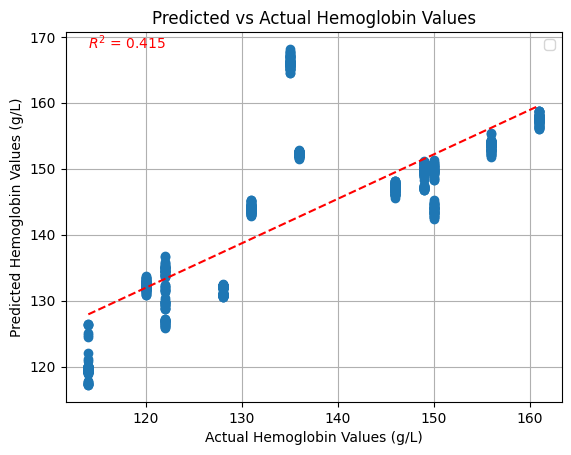

In [38]:
# Fit a line: y = m*x + b
m, b = np.polyfit(targets_np, predictions_np, 1)
x = np.array([min(targets_np), max(targets_np)])
line = m * x + b

# Calculate R^2
r2 = r2_score(targets_np, predictions_np)

# Plot
plt.plot(targets_np, predictions_np, 'o')
plt.plot(x, line, 'r--')
plt.text(min(targets_np), max(predictions_np), f'$R^2$ = {r2:.3f}', fontsize=10, color='red')

plt.xlabel("Actual Hemoglobin Values (g/L)")
plt.ylabel("Predicted Hemoglobin Values (g/L)")
plt.title("Predicted vs Actual Hemoglobin Values")
plt.legend()
plt.grid(True)
plt.show()

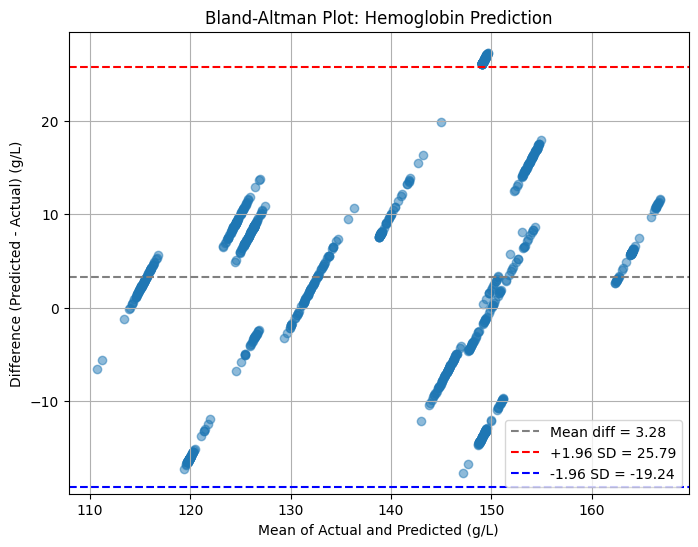

In [30]:
# Calculate the average and difference
avg = (predictions_np + targets_np) / 2
diff = predictions_np - targets_np  # Difference between predicted and actual
mean_diff = np.mean(diff)
std_diff = np.std(diff)

# Limits of agreement
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(avg, diff, alpha=0.5)
plt.axhline(mean_diff, color='gray', linestyle='--', label=f'Mean diff = {mean_diff:.2f}')
plt.axhline(loa_upper, color='red', linestyle='--', label=f'+1.96 SD = {loa_upper:.2f}')
plt.axhline(loa_lower, color='blue', linestyle='--', label=f'-1.96 SD = {loa_lower:.2f}')

plt.xlabel('Mean of Actual and Predicted (g/L)')
plt.ylabel('Difference (Predicted - Actual) (g/L)')
plt.title('Bland-Altman Plot: Hemoglobin Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
printed_vals = []
for val in targets_np:
  if val not in printed_vals:
    printed_vals.append(val)
    print(val)

146.0
128.0
149.0
136.0
156.0
161.0
114.0
122.0
131.0
135.0
120.0
150.0


In [32]:
print(predictions_np)

[161.37428  124.365265 150.60779  163.00714  142.98575  124.950325
 171.70435  117.01068  129.50885  143.54965  161.12488  141.361
 163.00714  129.37717  141.62357  116.03754  116.45268  160.7508
 142.6677   141.43839  143.09735  114.99473  163.36948  143.79387
 130.09392  128.82123  124.48227  163.96332  134.29172  122.975296
 143.5036   130.61253  130.48654  139.32312  142.77734  111.798775
 162.34103  131.32555  160.6261   116.12604  160.12729  160.7508
 142.66367  112.17306  143.526    171.81519  142.51141  131.65765
 116.02488  166.79803  141.8298   142.57274  152.96419  162.15259
 157.10492  166.8241   142.71977  161.99777  141.56935  129.50885
 116.71437  111.798775 125.64009  162.37189  162.50755  162.6741
 162.34103  143.00555  147.1414   129.15782  149.88425  163.04224
 162.37189  162.17862  130.61253  110.68942  143.1157   155.25693
 145.74979  132.87338  163.66333  162.99538  116.31008  128.18828
 117.15328  129.18651  119.1732   111.941376 162.6741   166.85013
 145.9259   